In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import dlc_pratical_prologue as prologue
from loading_datas import  generate_pair_sets
import matplotlib.pyplot as plt
import numpy as np

## Data set


In [ ]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

In [3]:
# Double checking
print("Training Set")
print(train_input.size())
print(train_target.size())
print(train_classes.size())
print("-------------------")
print("Testing Set")
print(test_input.size())
print(test_target.size())
print(test_classes.size())

Training Set
torch.Size([1000, 2, 14, 14])
torch.Size([1000])
torch.Size([1000, 2])
-------------------
Testing Set
torch.Size([1000, 2, 14, 14])
torch.Size([1000])
torch.Size([1000, 2])


## Helping functions

In [4]:
"""
Input :-

model : Pytorch NN model
input_data : Tensor of N X 2 X 14 X 14
target_data : Tensor of N X 1
batch_size : Size of the batch

-----------------------------------

Output :-

The number of samples not well classified
"""
def compute_nb_errors(model, data_input, data_target,batch_size):

    nb_data_errors = 0

    for inputs, targets in zip(data_input.split(batch_size), data_target.split(batch_size)):
        output = model(inputs)
        _, predicted_classes = torch.max(output, 1)
        for k in range(len(targets)):
            if targets[k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1        
    return nb_data_errors

"""
Input :-

model : Pytorch NN model
train_input : Tensor of N x 2 x 14 x 14
train_target : Tensor of N x 1
train_classes : Tensor of N x 2

test_input : Tensor of N x 2 x 14 x 14
test_target : Tensor of N x 1
test_classes : Tensor of N x 2

epochs : the number of passes of the entire training dataset
eta : learning parameter

batch_size : Size of the batch

-----------------------------------

Output :-

The number of samples not well classified

"""
eta = 0.01
def training_model(model,
                   train_input,train_target,train_classes,
                   test_input,test_target,test_classes,
                   eta,epochs = 25,
                   batch_size = 50):
  
  test_acc = [0] * epochs

  # define criterion and optimizer
  # need to check the other possibilities
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr = eta)

  for e in range(0,epochs):

    for inputs,target in zip(train_input.split(batch_size),train_target.split(batch_size)):

      outputs = model(inputs)
      loss = criterion(outputs, target)

      # optimising parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

  
    train_acc = 0
    train_acc = 100 * (1 - compute_nb_errors(model, train_input, train_target,batch_size)/train_input.size(0))
    test_acc[e] = 100 * (1 - compute_nb_errors(model, test_input, test_target,batch_size)/test_input.size(0))
    # print(f"Epoch # {e+1} / Train accuracy (%): {train_acc:.2f} / Test accuracy (%): {test_acc:.2f}")
     


  return test_acc
  



## Models

In [5]:
# parameters
eta = 0.01

In [6]:

# Net without Weight sharing
class Net1(nn.Module):
  def __init__(self):
    super(Net1,self).__init__()

    self.conv11 = nn.Conv2d(1,16,3)
    self.conv12 = nn.Conv2d(16,32,3)

    self.conv21 = nn.Conv2d(1,16,3)
    self.conv22 = nn.Conv2d(16,32,3)

    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))
    c1 = self.pool(c1)
    c1 = F.relu(self.conv12(c1))
    

    # Channel 2
    c2 = F.relu(self.conv21(c2))
    c2 = self.pool(c2)
    c2 = F.relu(self.conv22(c2))
    
    # Reconstruction
    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)

    # Classifier
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output

# Net with Weight sharing
class Net2(nn.Module):
  def __init__(self):
    super(Net2,self).__init__()
    
    self.conv1 = nn.Conv2d(1,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv1(c1))
    c1 = self.pool(c1)
    c1 = F.relu(self.conv2(c1))

    # Channel 2
    c2 = F.relu(self.conv1(c2))
    c2 = self.pool(c2)
    c2 = F.relu(self.conv2(c2))


    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)
   
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output



In [7]:
# Net without weight sharing
model1 = Net1()
train_acc = training_model(model1,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 10,batch_size = 50)

In [8]:
# Net with weight sharing
model2 = Net2()
train_acc = training_model(model2,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 10,batch_size = 50)

## Performance evaluation

### Runs

In [10]:
nb_round = 30
N = 1000
test_acc_1 = []
test_acc_2 = []
epochs = 30

for i in range(nb_round):
  train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
  model = Net1() # change here to different model
  test_acc = training_model(model,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 30,batch_size = 50)
  test_acc_1.append(test_acc)


for i in range(nb_round):
  train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
  model = Net2() # change here to different model
  test_acc = training_model(model,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 30,batch_size = 50)
  test_acc_2.append(test_acc)

### Plots

In [18]:
def plot(label_1,label_2):
  Model_1_mean = [0] * epochs
  Model_1_std = [0] * epochs
  Model_2_mean = [0] * epochs
  Model_2_std = [0] * epochs

  for e in range(epochs):
    Model_1_mean[e] = np.mean([row[e] for row in test_acc_1])
    Model_1_std[e] = np.std([row[e] for row in test_acc_1])
    Model_2_mean[e] = np.mean([row[e] for row in test_acc_2])
    Model_2_std[e] = np.std([row[e] for row in test_acc_2])

  epochs_x = list(range(1,epochs+1))
  fig, ax = plt.subplots()
  plt.grid()

  ax.plot(epochs_x,Model_1_mean, color='r', label=label_1)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_1_mean, Model_1_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_1_mean, Model_1_std)]), color='r', alpha=.3)

  ax.plot(epochs_x,Model_2_mean, color='b', label=label_2)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_2_mean, Model_2_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_2_mean, Model_2_std)]), color='b', alpha=.3)

  plt.legend()
  fig.set_size_inches(18.5, 10.5)
  fig.set_dpi(150) 
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Test Accuracy in [%]', fontsize=10)
  plt.show()
  

### Final Run

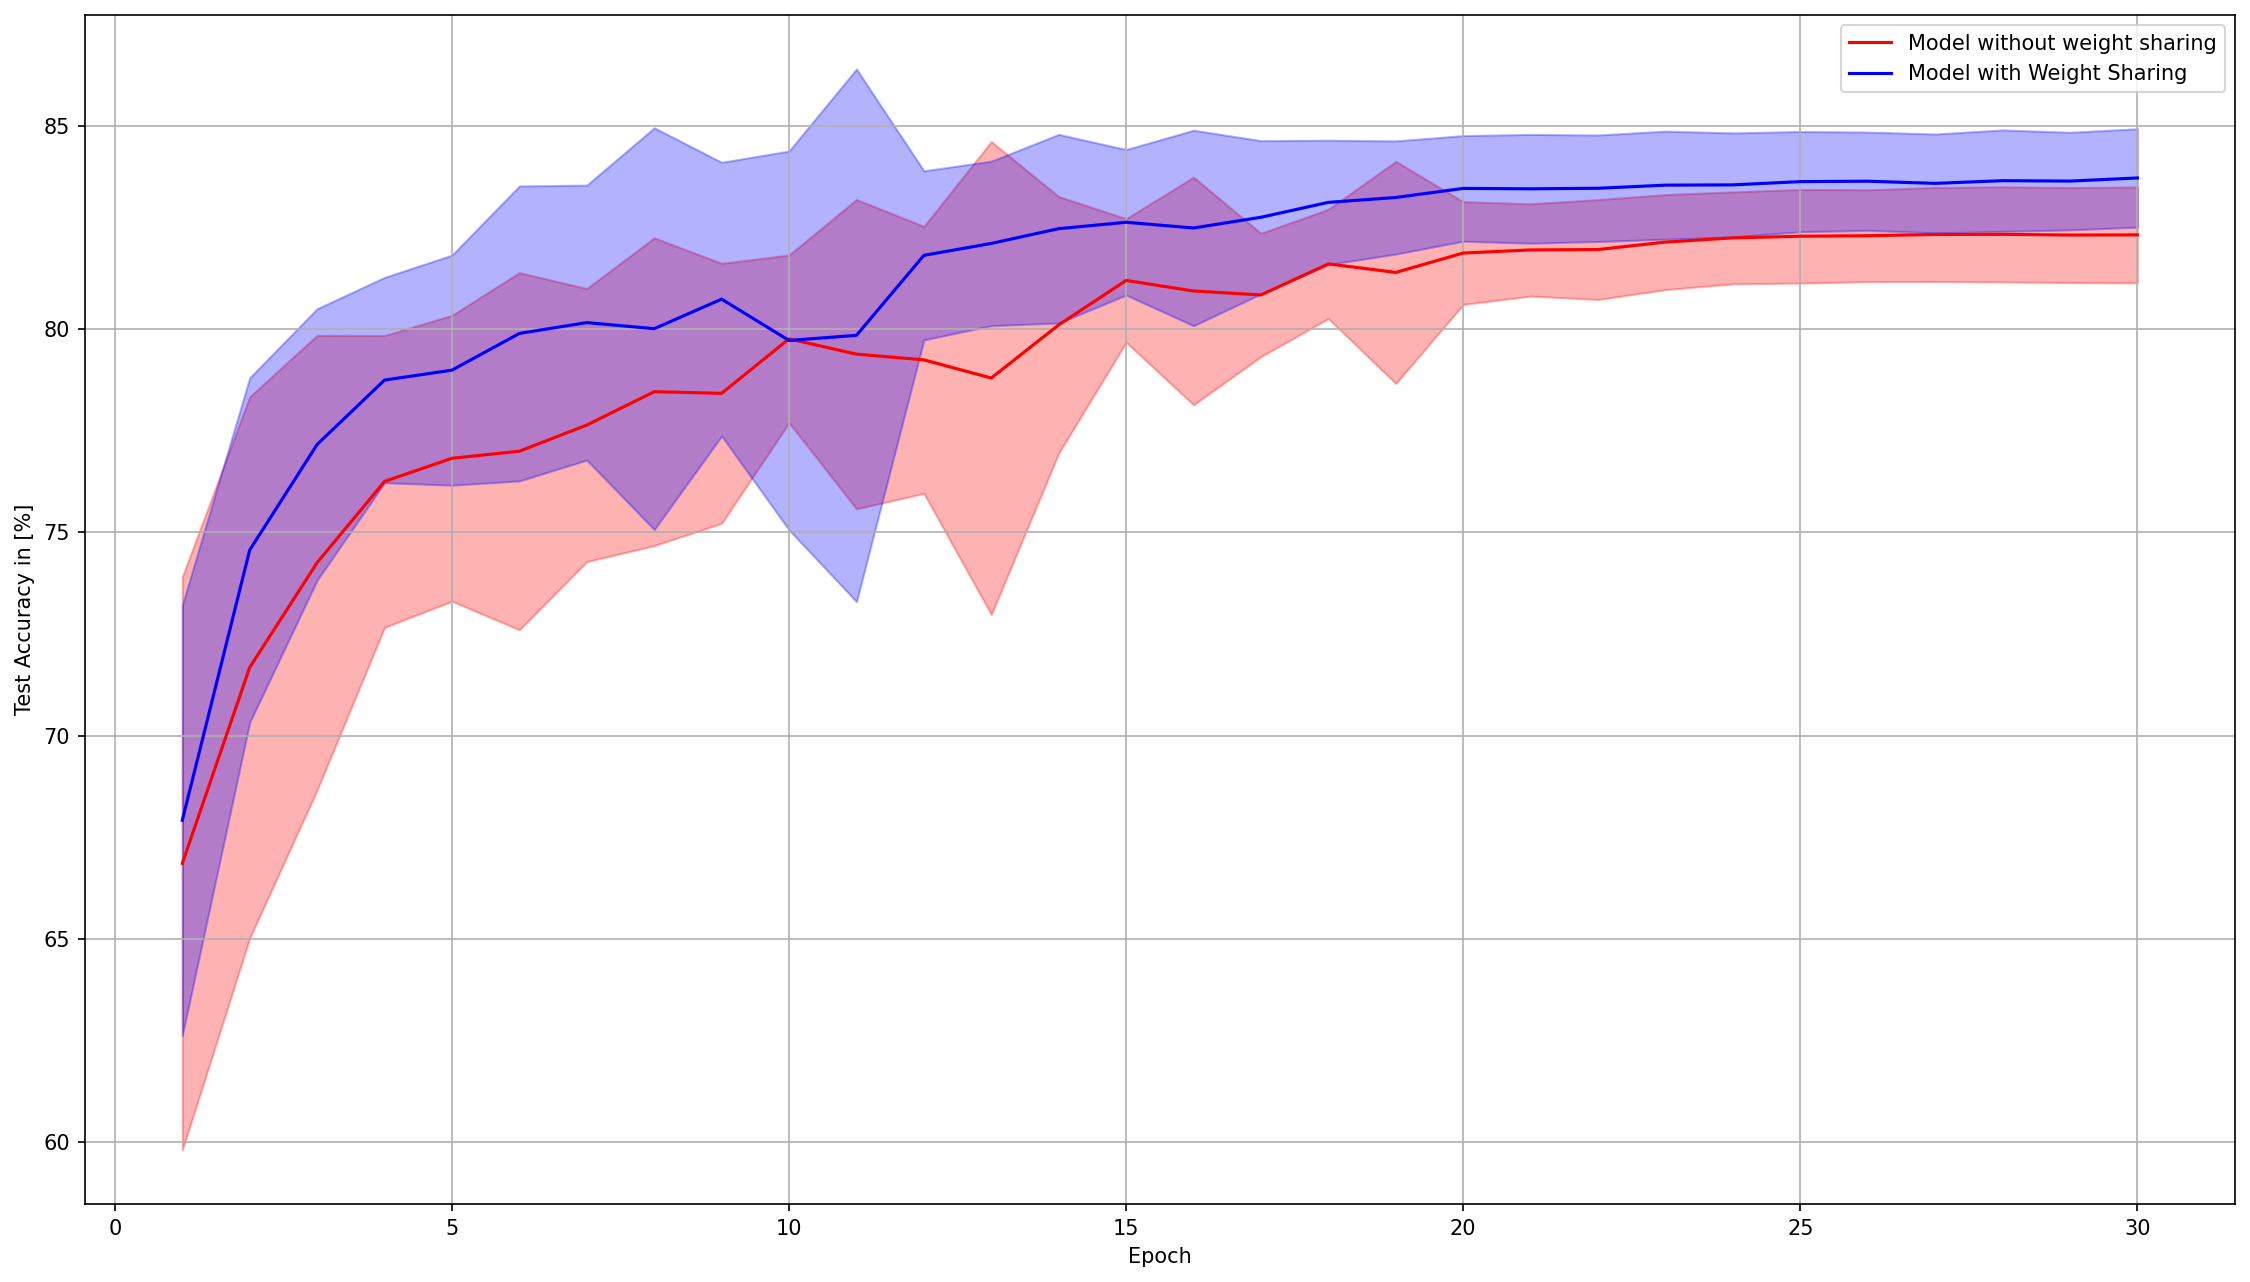

In [20]:
plot('Model without weight sharing','Model with Weight Sharing')